# Optimizing a Matrix Multiplication Algorithm
by Henry Atkins

In [ ]:
import multiprocessing
import seaborn as sb
import pandas as pd
import numpy as np
from numba import njit, prange
import matplotlib.pyplot as plt
%matplotlib inline

def matrix_product_original(mat_a, mat_b):
    """Returns the product of the matrices mat_a and mat_b. 
       Known as Original from here."""
    m = mat_a.shape[0]
    n = mat_b.shape[1]
    assert(mat_a.shape[1] == mat_b.shape[0])
    ncol = mat_a.shape[1]

    mat_c = np.zeros((m, n), dtype=np.float64)

    for row_ind in range(m):
        for col_ind in range(n):
            for k in range(ncol):
                mat_c[row_ind, col_ind] += mat_a[row_ind, k] * mat_b[k, col_ind]
    return mat_c

################################################################################

@njit(parallel=True) 
# njit machine compiles this function, and the parallel allows 
#it to be parallelized.    
def matrix_product_numba_Parallel(mat_a, mat_b):
    """Returns the product of the matrices mat_a and 
    mat_b with Numba (parallel) optimised."""
    m = mat_a.shape[0]
    n = mat_b.shape[1]

    assert(mat_a.shape[1] == mat_b.shape[0])

    ncol = mat_a.shape[1]

    mat_c = np.zeros((m, n), dtype=np.float64)

    for row_ind in prange(m): #prange parallelizes this loop.
        for col_ind in range(n): 
            for k in range(ncol): 
                mat_c[row_ind, col_ind] += mat_a[row_ind, k] * mat_b[k, col_ind]

    return mat_c
################################################################################

@njit(parallel=True) #Parellelization is allowed
def matrix_product_numba_Series(mat_a, mat_b):
    """Returns the product of the matrices mat_a and mat_b 
    with Numba (series) optimised."""
    m = mat_a.shape[0]
    n = mat_b.shape[1]

    assert(mat_a.shape[1] == mat_b.shape[0])

    ncol = mat_a.shape[1]

    mat_c = np.zeros((m, n), dtype=np.float64)

    for row_ind in range(m): #This is not parallelized, so is in series.
        for col_ind in range(n): 
            for k in range(ncol): 
                mat_c[row_ind, col_ind] += mat_a[row_ind, k] * mat_b[k, col_ind]

    return mat_c

################################################################################

@njit(parallel=True)            #njit machine compiles the function
def matrix_product_cache(mat_a, mat_b):
    """Returns the product of the matrices mat_a and mat_b with 
       cache (mat_b is in Fortran form) optimised."""
    mat_b = np.asfortranarray(mat_b) #This loads matrix b as an F-style matrix.
    m = mat_a.shape[0]
    n = mat_b.shape[1]

    assert(mat_a.shape[1] == mat_b.shape[0])

    ncol = mat_a.shape[1]

    mat_c = np.zeros((m, n), dtype=np.float64)

    for row_ind in prange(m): 
        for col_ind in range(n): 
            for k in range(ncol): 
                mat_c[row_ind, col_ind] += mat_a[row_ind, k] * mat_b[k, col_ind] 
    #b being a F-style matrix means this multiplication is faster, 
    #as the mat_b[k+1, col_ind] is the subsequent data in the cache.

    return mat_c

################################################################################









@njit()            #njit machine compiles the function
def matrix_product_blocking(mat_a, mat_b, block_size):
    """Returns the product of the matrices mat_a and mat_b. 
       Known as Original from here.
       https://stackoverflow.com/questions/40050761/python-matrix-multiplication-and-caching
       was used as inspiration."""


    m = mat_a.shape[0]
    n = mat_b.shape[1]
    assert(mat_a.shape[1] == mat_b.shape[0])
    ncol = mat_a.shape[1]
    mat_c = np.zeros((m, n), dtype=np.float64)

    for row_ind in prange(0, m, block_size): 
      #moving through mat_a horizontally in steps of block_size
        for col_ind in range(0, n, block_size):
          #moving through mat_b vertically in block_size steps
            for i in range(ncol): 
              #looping through sub-matrix
              a = mat_a[i] #intermediary matrix
              c = mat_c[i]
              for j in range(col_ind, col_ind+block_size): 
                #each step in sub-matrices
                s = c[j]
                for k in range(row_ind, row_ind+block_size):
                  s += a[k] * mat_b[k][j]
                c[j] = s
    return mat_c
  
multiprocessing.cpu_count() # Count the number of cores in a computer From open source

2

In [ ]:
mat_sizes = [20, 50, 100, 200, 300, 500] 
# A max matrix size of 500 x 500 takes Google Colab 20min to execute this cell, 
#so we cannot calculate larger.

numpy_times, original_times, numba_parallel_times, 
  numba_series_times, cached_times, blocked_times = [], [], [], [], [], []

for i in mat_sizes:    

  """This loop calculates all the functions times on identical A,B matricies."""

  print("Calculating Matrix of size: ", i) #For watching the cell execute over long periods.
  a = np.random.randn(i, i)
  b = np.random.randn(i, i)

  time_numpy = %timeit -oq np.dot(a, b)
  time_original = %timeit -oq matrix_product_original(a, b)
  time_numba_parallel = %timeit -oq matrix_product_numba_Parallel(a, b)
  time_numba_series = %timeit -oq matrix_product_numba_Series(a, b)
  time_cached = %timeit -oq matrix_product_cache(a, b)
  time_blocked = %timeit -oq matrix_product_blocking(a, b, block_size=10)

  numpy_times.append(time_numpy.best)
  original_times.append(time_original.best)
  numba_parallel_times.append(time_numba_parallel.best)
  numba_series_times.append(time_numba_series.best)
  cached_times.append(time_cached.best)
  blocked_times.append(time_blocked.best)


Calculating Matrix of size:  20
Calculating Matrix of size:  50
Calculating Matrix of size:  100
Calculating Matrix of size:  200
Calculating Matrix of size:  300
Calculating Matrix of size:  500


# Speed of Numpy vs Original Function

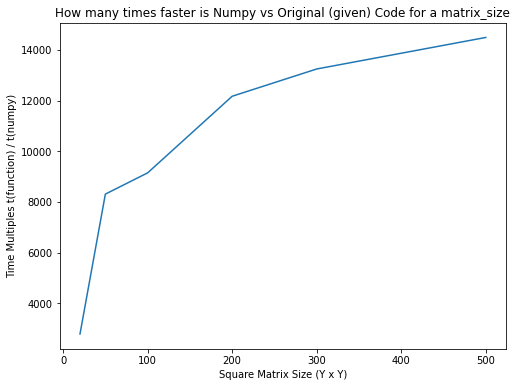

In [ ]:
%matplotlib inline
plt.figure(figsize=(8, 6))
plt.title("How many times faster is Numpy vs Original (given) Code for a matrix_size")
plt.xlabel("Square Matrix Size (Y x Y)")
plt.ylabel("Time Multiples t(function) / t(numpy)")
plt.plot(mat_sizes, np.array(original_times)/np.array(numpy_times))

Numpy is an optimised package mostly compiled in C code, which can be used to improve the speed of numerical python calculations. 

Numpy is expected to create a much faster (the fastest of all the functions) calculation, as it compiles the arithmatic outside of the python interpreter, and makes use of BLAS functionality. 

Numpy also reserves consecutive chunks of memory for the same data. This means consecutive elements in lists are stored one-after-the-other, reducing the time required to 'search' for that elements index in the main memory; it is in the cache, or easy to access in the main memory. 

This removes the greatest speed reduction when using python code. Bouncing between the python interpreter and machine code (as the for loop method does) is very slow. 


As expected, the numpy.dot() function is a factor of ~10,000 times faster. The inverse exponential (which appears to tend towards 15,000 times faster) arrises from the cubic relationship between calculation number and matrix size. As numpy is faster, larger matrices have growing differences between the numpy time (numerator) and the original (denominator) so the gradient tends to $constant / inf $ which tends to zero. This relationship repeats in future graphs.

# Speed of Parallel vs Series Functions

Parallelizing this code was done with Numba. Numba is a just-in-time compiler, and works with python. It achieves high speeds by using LLVM compiler infrastructure to translate python code into machine code. A good attribute of Numba is its cache, after it has completed a function and translated it to machine code, it is temporarily saved. This means that computation intensive loops can be recalled, and any numpy/supported functions can be reused at very little computational cost. 
To optimise the code with JIT, I added the @njit(Parallel=True) command before each function definition. This statement machine compiles the code so we can access it quickly later. I also change the (row_ind in range(m)) loop to (for row_ind in prange(m)) which parallelizes the loop. This may only be ran once, as the prange() function distributes the loop to cores. If a loop distributes its tasks, and then any nested loops try to distribute their tasks to the same cores there is a clash of data, and an eventual slowdown. This means that the largest loop shoud be used, and this was tested 

I expect the parallelised code to be twice as fast, as the free version of Google Colab uses 2 cores (running in parallel will be identical).  The below plot shows how many times faster the Parallelized function is over the Original (Series) function. 

As expected, it is found that the Parallel function takes about half the time of the Series function. This is becasue the outer for loop has been split between the two cores. The fact that it is not a constant factor speed up (constant distribution around 2) implies thaat there is some overhead in the parallelization. This was not considered above, and for increasing matrix size the parallel apears to loose some of its edge (note the downtrend as mat_size > 200). This is possibly a unique performance issue on this PC's Google Colab, but as there is not any immediate google discussions on this topic, it may be an area of further work (identifying the problem). 

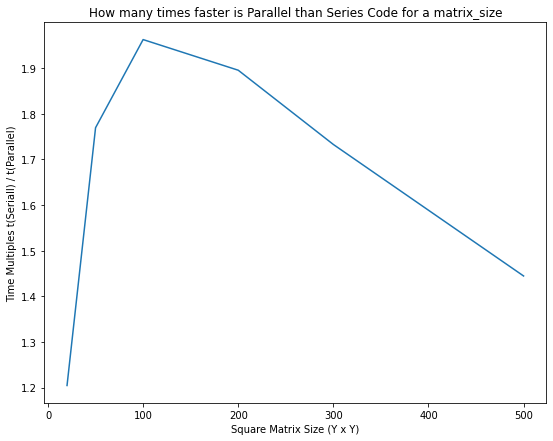

In [ ]:

plt.figure(figsize=(9, 7))
plt.title("How many times faster is Parallel than Series Code for a matrix_size")
plt.xlabel("Square Matrix Size (Y x Y)")
plt.ylabel("Time Multiples t(Seriall) / t(Parallel)")
plt.plot(mat_sizes, np.array(numba_series_times)/np.array(numba_parallel_times))

# Speed of C-Style vs F-Style (Cache optimizing)

Rewriting the second matrix B as a Fortran-style matrix helps the CPU find the element data faster. This is because the CPU forms a cache of the next few datapoints. In a C-style matrix the data is in Row major configuration (the next column along is the next datapoint) while a F-style matrix is in a Column major format. This means that for F-Style, the 'next' datapoint in the matrix lies vertically down from the last. In matrix multiplication, the B matrix is looped down each column, so the CPU has the advantage of data locality in this configuration. This works, and should be faster, as long as we are traversing the data in the order it is laid out, as bouncing between the main memory and the python interpreter is a very slow process. Therefore, we convert matrix b (mat_b) to a Fortran-Style matrix, with the " mat_b=np.asfortranarray(mat_b) " command. It is expected that the speed of the Fortran-Style will be less, although as no parallelization is occuring, it will not be by an order of magnitude.

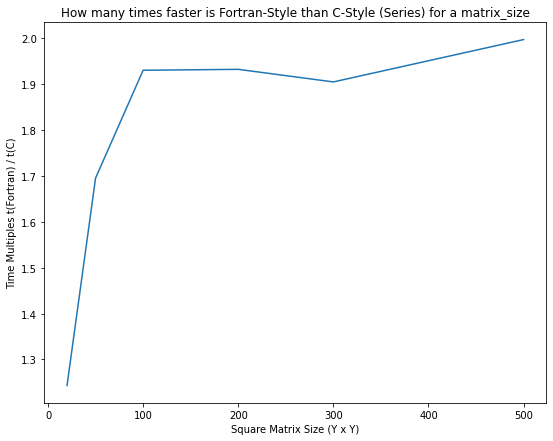

In [ ]:
plt.figure(figsize=(9, 7))
plt.title("How many times faster is Fortran-Style than C-Style (Series) for a matrix_size")
plt.xlabel("Square Matrix Size (Y x Y)")
plt.ylabel("Time Multiples t(Fortran) / t(C)")
plt.plot(mat_sizes, np.array(numba_series_times)/np.array(cached_times))

The above graph shows that the Fortran-Style takes about half as long to run as the C-Style. This implies that half the time of the C-Style Series algorithm is spend accessing memory for subsequent data, as imputting that data to the cache gives a 50% time reduction. 

# Matrix Multiplication with Blocking

Blocking is a method to speed up the calculation of matrix products by splitting the larger matrices into sub-matricies. In theory, matrix multiplication may be conducted on these sub-matricies and collated into the final answer. 

Below, there is a heatmap of sub-Matrix vs Matrix size with time as colour. This allows us to pick the optimum square matrix_size to loop over while testing the impact of different sub-Matrix sizes. Square matrix sizes up to 500 are tested as this cell runs for ~20min so larger msquare matrices could not be tested for all sub-matrix sizes. Please note that elements of the Heatmap with sub-matrix > square matrix should be discarded, as they are useless. 

In [ ]:
ls = [2, 4, 5, 8, 10, 20, 50]
mat_sizes = [10, 50, 100, 200, 300, 400, 500]
block_l_s_times = np.empty((len(ls), len(mat_sizes)), dtype=np.float64)
for l in range(len(ls)):
  for i in range(len(mat_sizes)):
    a = np.random.randn(mat_sizes[i], mat_sizes[i])
    b = np.random.randn(mat_sizes[i], mat_sizes[i])
    time_blocked = %timeit -oq matrix_product_blocking(a, b, ls[l])
    block_l_s_times[l, i] = time_blocked.best
#print(np.array(block_l_s_times))
block_l_s_times = pd.DataFrame(block_l_s_times, ls, mat_sizes)

Text(60.0, 0.5, 'sub-Matrix sizes (l x l)')

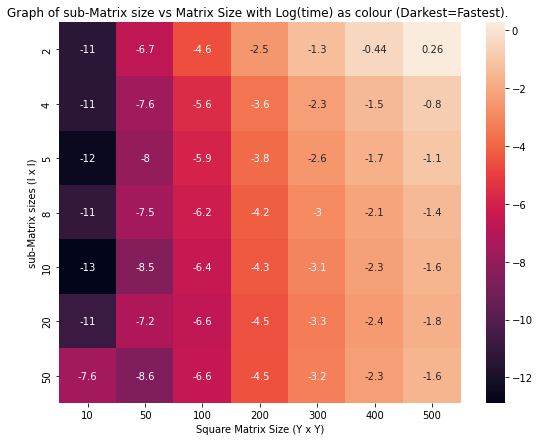

In [ ]:
plt.figure(figsize=(9, 7))
sb.heatmap(np.log(block_l_s_times), annot=True)
plt.title("Graph of sub-Matrix size vs Matrix Size with Log(time) as colour (Darkest=Fastest). ")
plt.xlabel("Square Matrix Size (Y x Y)")
plt.ylabel("sub-Matrix sizes (l x l)")

A square matrix size of 200 x 200 was chosen, as it is large enough to use all the sub-matrix sizes, and is small enough to be ran fast.


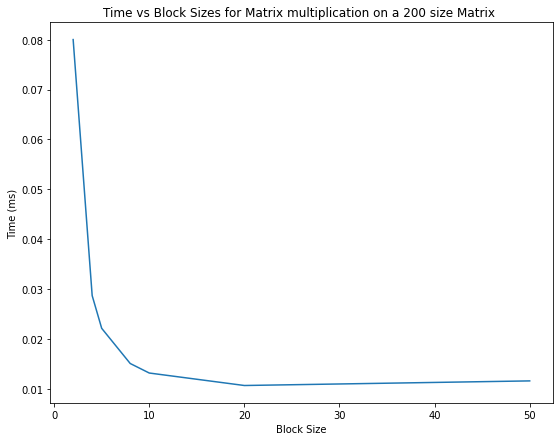

In [ ]:
times = np.array(block_l_s_times[200])

plt.figure(figsize=(9, 7))
plt.title("Time vs Block Sizes for Matrix multiplication on a 200 size Matrix ")
plt.xlabel("Block Size")
plt.ylabel("Time (ms)")
plt.plot(ls, times)

As you can see, the larger the block, the faster the calculation. The exponential decay is due to the expansion over 2-dimensions, as you increase the size of a submatrix from 2 to 4, the elemnents included follow 4 to 16, a square. This exponential growth of included elements (which calculations are conducted on) causes an exponential decay of calculations outside the sub-Matrix. 

So, is Blocking better than the previous methods? Below is plotted the 'times-faster' graph of Blocked (sub-matrix size = 10) vs Cache optimized. As you can see, the Cache optimized algorithm is twice as fast, ie blocked takes ~2 times longer.

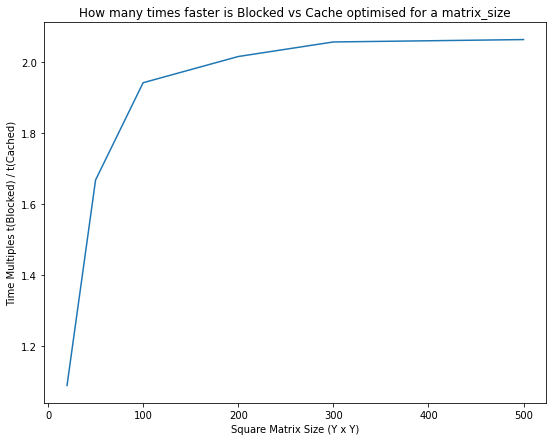

In [ ]:
plt.figure(figsize=(9, 7))
plt.title("How many times faster is Blocked vs Cache optimised for a matrix_size")


plt.xlabel("Square Matrix Size (Y x Y)")
plt.ylabel("Time Multiples t(Blocked) / t(Cached)")
plt.plot(mat_sizes, np.array(blocked_times)/np.array(cached_times))
plt.show()

In [ ]:
print(numpy_times[0], original_times[0], numba_parallel_times[0], numba_series_times[0], cached_times[0], blocked_times[0])

2.555297750000136e-06 0.00711709633999817 1.3832000149704982e-05 1.6357000276912004e-05 1.2910999885207275e-05 1.4045000170881394e-05


To conclude, the Numpy module is the fastest at 2.56 microsec, followed by the Cache optimized at 1.2 micro sec. The original given function is slowest (this was the limiting function when doing calculations) at 7 ms.   

This shows how parallelization and caching can decrease the computation times by a factor of ~550. These factors are crucial to consider when writing code, as inefficient use of these may impede the problem solving abilities of an algorithm. A slow root finder may be useless, but considering these when constructing an algorithm lets us ensure order-of-magnitude imporovements from naive code.